# Fútbol bayesiano

Carga de librerías

In [1]:
import os
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from predictiva_previa import ajuste_previa_predictiva, plot_histogram
from cmdstanpy import CmdStanModel
from ipywidgets import widgets

Se definen rutas relativas del archivo

In [2]:
CURRENT = os.getcwd()
ROOT = os.path.dirname(CURRENT)

Cargar en memoria archivo de configuración

In [3]:
with open(os.path.join(ROOT, 'config.yml'), 'r') as file_:
    config = yaml.safe_load(file_)
file_.close()

Carga en memoria de los datos

In [8]:
df_ = (
    # --------------------------------------------------- Carga de datos crudos
    pd.read_csv(
        os.path.join(ROOT, config['datos']['raw'])
        ,encoding='latin1')
    # ---------------------------------------------------- Acotar datos a scope
    .query("year > 2018")
    .query("tournament == 'FIFA World Cup qualification'")
    .reset_index(drop=True)
    # --------------------------------------------- Filtrar columnas de interés
    .filter(items=[
        'date'
        ,'tournament'
        ,'home_team'
        ,'away_team'
        ,'home_team_continent'
        ,'away_team_continent'
        ,'home_team_score'
        ,'away_team_score'
    ])
    # ------------------------------------ Transformación a columnas existentes
    .assign(
        date = lambda df_: pd.to_datetime(df_.date)
        ,home_team = lambda df_: pd.Categorical(df_.home_team)
        ,away_team = lambda df_: pd.Categorical(df_.away_team)
        ,home_team_continent = lambda df_: pd.Categorical(df_.home_team_continent)
        ,away_team_continent = lambda df_: pd.Categorical(df_.away_team_continent)
    )
    # --------------------------------------- Asignación de columnas computadas
    .assign(
        result = lambda df_: 
            # -1: Away win, 0: Draw, 1: Home win
            (df_.home_team_score - df_.away_team_score).apply(np.sign)
    )
    .sort_values(by="date", ascending=True)
)

df_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 863 entries, 0 to 862
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 863 non-null    datetime64[ns]
 1   tournament           863 non-null    object        
 2   home_team            863 non-null    category      
 3   away_team            863 non-null    category      
 4   home_team_continent  863 non-null    category      
 5   away_team_continent  863 non-null    category      
 6   home_team_score      863 non-null    int64         
 7   away_team_score      863 non-null    int64         
 8   result               863 non-null    int64         
dtypes: category(4), datetime64[ns](1), int64(3), object(1)
memory usage: 65.3+ KB


In [18]:
df_

,date,tournament,home_team,away_team,home_team_continent,away_team_continent,home_team_score,away_team_score,result
0,2019-06-06,FIFA World Cup qualification,Bhutan,Guam,Asia,Asia,1,0,1
1,2019-06-06,FIFA World Cup qualification,Cambodia,Pakistan,Asia,Asia,2,0,1
2,2019-06-06,FIFA World Cup qualification,Laos,Bangladesh,Asia,Asia,0,1,-1
3,2019-06-06,FIFA World Cup qualification,Macau,Sri Lanka,Asia,Asia,1,0,1
4,2019-06-06,FIFA World Cup qualification,Mongolia,Brunei Darussalam,Asia,Asia,2,0,1
...,...,...,...,...,...,...,...,...,...
856,2022-03-30,FIFA World Cup qualification,Panama,Canada,North America,North America,1,0,1
859,2022-06-01,FIFA World Cup qualification,Scotland,Ukraine,Europe,Europe,1,3,-1
860,2022-06-05,FIFA World Cup qualification,Wales,Ukraine,Europe,Europe,1,0,1
861,2022-06-13,FIFA World Cup qualification,Australia,Peru,Oceania,South America,0,0,0


In [19]:
df_['time'] = (df_['date'] - df_['date'].min()).dt.days + 1
# Número de partidos, equipos y momentos en el tiempo
encoder = LabelEncoder()
encoder.fit(pd.concat([df_['home_team'], df_['away_team']]))

df_['team1'] = encoder.transform(df_['home_team']) + 1  
df_['team2'] = encoder.transform(df_['away_team']) + 1

# Número de partidos y equipos
N = len(df_)
K = len(encoder.classes_)
T = df_['time'].max()

data = {
  'N': N,
  'K': K,
  'T': T,
  'team1': df_['team1'].tolist(),
  'team2': df_['team2'].tolist(),
  'y1': df_['home_team_score'].tolist(),
  'y2': df_['away_team_score'].tolist(),
}

In [17]:
df_.date.nunique()

79

# 2. Modelo en STAN

$$y^h\sim Poisson(\theta^h)$$
$$y^a\sim Poisson(\theta^a)$$
$$log(\theta^h) = home_{boost} + attack_{i[h]} - defence_{i[a]} + intercept$$
$$log(\theta^a) = attack_{i[a]} - defence_{i[h]} + intercept$$

## 2.1. Muestreo

Primero se definen algunas funciones útiles para la creación y manipulación de archivos de `stan`, y se crea un proyecto nuevo para la primera iteración del modelo jerárquico.

In [23]:
import BFG3000 as bfg

In [24]:
name = 'dinamico_real_predictiva_previa'
sp_ = bfg.StanProject(name)
dir_, model_ = sp_.create_stan_project(dir='modelos')

Ya existe un proyecto con el nombre dinamico_real_predictiva_previa


Una vez creado y editado el proyecto de STAN, se declara el siguiente bloque de código para mantener estructura en la compilación del modelo y los archivos que éste genera.

In [25]:
# Compilar el modelo
compile_ = CmdStanModel(
    model_name=name
    ,stan_file=model_
    ,compile=True)

22:37:23 - cmdstanpy - INFO - compiling stan file /home/juanpalms/Desktop/MCD/Metodos analiticos/PROYECTO/futbol_bayes/modelos/dinamico_real_predictiva_previa/dinamico_real_predictiva_previa.stan to exe file /home/juanpalms/Desktop/MCD/Metodos analiticos/PROYECTO/futbol_bayes/modelos/dinamico_real_predictiva_previa/dinamico_real_predictiva_previa
22:37:41 - cmdstanpy - INFO - compiled model executable: /home/juanpalms/Desktop/MCD/Metodos analiticos/PROYECTO/futbol_bayes/modelos/dinamico_real_predictiva_previa/dinamico_real_predictiva_previa
22:37:41 - cmdstanpy - WARNING - Stan compiler has produced 4 warnings:
22:37:41 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/tmp/tmpvo3mhllp/tmpihrqconf.hpp /tmp/tmpvo3mhllp/tmpihrqconf.stan
Warning in '/tmp/tmpvo3mhllp/tmpihrqconf.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword befo

Se delcara un diccionario de datos para proporcionar los datos a stan

In [8]:
encoder = LabelEncoder()
encoder.fit(pd.concat([df_['home_team'], df_['away_team']]))

df_['team1'] = encoder.transform(df_['home_team']) + 1  
df_['team2'] = encoder.transform(df_['away_team']) + 1

# Número de partidos y equipos
N = len(df_)
K = len(encoder.classes_)

data = {
  'N': N,
  'K': K,
  'team1': df_['team1'].tolist(),
  'team2': df_['team2'].tolist(),
  'y1': df_['home_team_score'].tolist(),
  'y2': df_['away_team_score'].tolist(),
}

Finalmente, se ejecuta el modelo y se calibra. Este paso es recursivo y se tiene que ejecutar tantas veces sean necesarias de modo que las cadenas generadas por el muestreador tengan diagnósticos buenos.

In [26]:
fit_ = compile_.sample(
    data=data
    ,chains=2
    ,iter_warmup=1_0
    ,iter_sampling=2_0
    ,show_progress=True
    ,save_warmup=False
)

22:37:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

22:44:09 - cmdstanpy - INFO - CmdStan done processing.
22:44:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpvo3mhllp/tmpihrqconf.stan', line 44, column 6 to column 69)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpvo3mhllp/tmpihrqconf.stan', line 44, column 6 to column 69)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpvo3mhllp/tmpihrqconf.stan', line 44, column 6 to column 69)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpvo3mhllp/tmpihrqconf.stan', line 44, column 6 to column 69)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpvo3mhllp/tmpihrqconf.stan', line 44, column 6 to column 69)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/tmpvo3mhllp/tmpihrqconf.stan', line 44, column 6 to column 69)
	Exception: normal_lpdf: Sca

22:44:13 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 20 divergent transitions (100.0%)
	Chain 2 had 20 divergent transitions (100.0%)
	Use function "diagnose()" to see further information.


In [27]:
diagnose_path = os.path.join(dir_, name + '_diagnose.txt')

with open(diagnose_path, 'w') as file_:
    file_.write(fit_.diagnose())
file_.close()

## 2.2 Resumen de estimadores

In [28]:
summary_ = fit_.summary()
summary_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 910525 entries, lp__ to defence[206,1105]
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Mean     910525 non-null  float64
 1   MCSE     910525 non-null  float64
 2   StdDev   910525 non-null  float64
 3   5%       910525 non-null  float64
 4   50%      910525 non-null  float64
 5   95%      910525 non-null  float64
 6   N_Eff    910525 non-null  float64
 7   N_Eff/s  910525 non-null  float64
 8   R_hat    910525 non-null  float64
dtypes: float64(9)
memory usage: 69.5+ MB


Número de parámetros

In [29]:
summary_vis_ = (
    summary_
    .reset_index(names='param')
    .assign(
        param = lambda df_: df_.param.str.partition('[')[0]
    )
)

summary_vis_.param.value_counts()

param
attack_raw       227630
defence_raw      227630
attack           227630
defence          227630
lp__                  1
home                  1
intercept             1
sigma_attack          1
sigma_defence         1
Name: count, dtype: int64

### 2.2.1 MCSE

Primero se observa el `MCSE` de lo parámetros únicos

In [30]:
# Datos de visualización
diagnostico = 'MCSE'
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() == 1].keys()

single_params = (
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
).param.values.to_list()

(
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

,param,MCSE
0,lp__,5218.400000
1,home,0.018647
2,intercept,0.376802
455263,sigma_attack,0.015000
455264,sigma_defence,0.014000


Visualización del error estándar MC de los parámetros múltiples

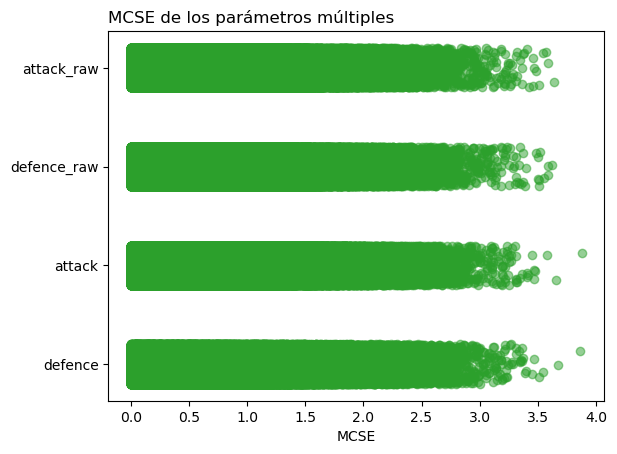

In [31]:
# Datos de visualización
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() > 1].keys()
vis_ = (
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

# Especificaciones de figuras
fig, ax = plt.subplots()

# Visualizaciones
ax.scatter(
    x=vis_[diagnostico]
    ,y=vis_.param.cat.codes + np.random.uniform(low=-0.2, high=0.2, size=vis_.shape[0])
    ,color='tab:green'
    ,alpha=0.5)

# Anotaciones y estilo
ax.set_title(f'{diagnostico} de los parámetros múltiples', loc='left')
ax.set_xlabel(diagnostico)
ax.set_yticks(
    ticks=vis_.param.cat.codes.unique()
    ,labels=vis_.param.cat.categories)

plt.show()

### 2.2.2 Número efectivo de simulaciones

Primero se observa el `N_Eff` de lo parámetros únicos

In [32]:
# Datos de visualización
diagnostico = 'N_Eff'
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() == 1].keys()

(
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

,param,N_Eff
0,lp__,1.17647
1,home,1.22992
2,intercept,1.17650
455263,sigma_attack,1.18100
455264,sigma_defence,1.18000


Visualización del error estándar MC de los parámetros múltiples

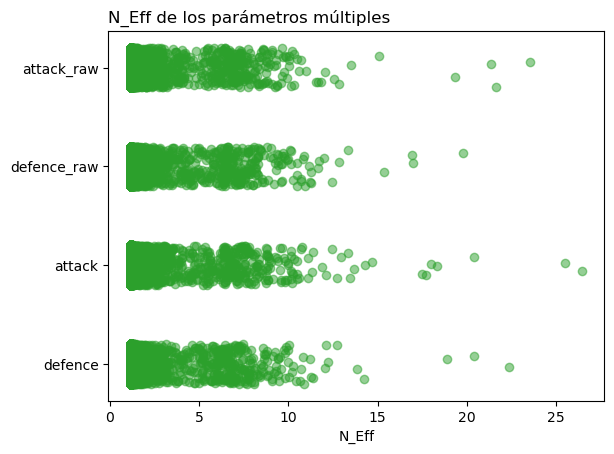

In [33]:
# Datos de visualización
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() > 1].keys()
vis_ = (
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

# Especificaciones de figuras
fig, ax = plt.subplots()

# Visualizaciones
ax.scatter(
    x=vis_[diagnostico]
    ,y=vis_.param.cat.codes + np.random.uniform(low=-0.2, high=0.2, size=vis_.shape[0])
    ,color='tab:green'
    ,alpha=0.5)

# Anotaciones y estilo
ax.set_title(f'{diagnostico} de los parámetros múltiples', loc='left')
ax.set_xlabel(diagnostico)
ax.set_yticks(
    ticks=vis_.param.cat.codes.unique()
    ,labels=vis_.param.cat.categories)

plt.show()

### 2.2.3 Factor de reducción de escala

Primero se observa el `R_hat` de lo parámetros únicos

In [34]:
# Datos de visualización
diagnostico = 'R_hat'
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() == 1].keys()

(
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

,param,R_hat
0,lp__,1556.0900
1,home,6.3758
2,intercept,238.2060
455263,sigma_attack,14.2420
455264,sigma_defence,18.0430


Visualización del error estándar MC de los parámetros múltiples

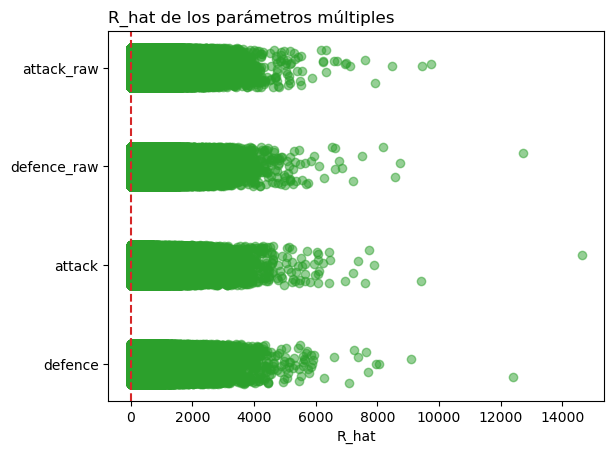

In [35]:
# Datos de visualización
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() > 1].keys()
vis_ = (
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

# Especificaciones de figuras
fig, ax = plt.subplots()

# Visualizaciones
ax.scatter(
    x=vis_[diagnostico]
    ,y=vis_.param.cat.codes + np.random.uniform(low=-0.2, high=0.2, size=vis_.shape[0])
    ,color='tab:green'
    ,alpha=0.5)
ax.axvline(x=1.05, color='tab:red', linestyle='--')

# Anotaciones y estilo
ax.set_title(f'{diagnostico} de los parámetros múltiples', loc='left')
ax.set_xlabel(diagnostico)
ax.set_yticks(
    ticks=vis_.param.cat.codes.unique()
    ,labels=vis_.param.cat.categories)

plt.show()

### 2.2.4 Traza de las cadenas

In [36]:
chains_ = fit_.draws(inc_warmup=False, concat_chains=False)
chains_.shape

(20, 2, 910531)

Parámetros simples

In [37]:
def traceplot_single_param(param, type):
    idp_ = fit_.column_names.index(param)
    arr_ = chains_[:, :, idp_]

    # Especificaciones de figura
    plt.figure(figsize=(10,5))

    if type == 'traceplot':
        # Visualizaciones
        for chain in range(arr_.shape[1]):
            plt.plot(arr_[:, chain], label=f'Chain: {chain}')

        # Anotaciones y estilo
        plt.title(f'Traza de las cadenas, {param}', loc='left')
        plt.xlabel('Iteraciones')
        plt.ylabel('Espacio parametral')
        plt.legend()

    if type == 'convergence':
        ergo_ = np.apply_along_axis(func1d=lambda x: x.cumsum(), axis=0, arr=arr_)
        ergo_ = ergo_ / np.arange(1, ergo_.shape[0]+1, 1).reshape((-1,1))

        # Visualizaciones
        for chain in range(ergo_.shape[1]):
            plt.plot(ergo_[:, chain], label=f'Chain: {chain}')

        # Anotaciones y estilo
        plt.title(f'Promedios ergódicos, {param}', loc='left')
        plt.xlabel('Iteraciones')
        plt.ylabel('Espacio parametral')
        plt.legend()

    plt.show()

In [38]:
widgets.interact(
    traceplot_single_param
    ,param=widgets.Dropdown(
        options=single_params
        ,description='Param'
        ,disabled=False)
    ,type=widgets.Dropdown(
        options=['traceplot','convergence']
        ,description='Type'
        ,disabled=False)
        
)

interactive(children=(Dropdown(description='Param', options=('lp__', 'home', 'intercept', 'sigma_attack', 'sig…

<function __main__.traceplot_single_param(param, type)>

# 3) Distribucion predictiva previa

In [40]:
modelString="""
data {
  int<lower=0> N;          // Número de partidos
  int<lower=0> K;          // Número de equipos
  int<lower=1,upper=K> team1[N];  // Índices de equipos locales
  int<lower=1,upper=K> team2[N];  // Índices de equipos visitantes
}

generated quantities {
  real home = normal_rng(0, 1);
  real intercept = normal_rng(0, 1);
  vector[K] attack_raw;
  vector[K] defence_raw;
  for (k in 1:K) {
    attack_raw[k] = normal_rng(0, 1);
    defence_raw[k] = normal_rng(0, 1);
  }
  vector[K] attack = attack_raw - mean(attack_raw);
  vector[K] defence = defence_raw - mean(defence_raw);
  
  int y1_sim[N];
  int y2_sim[N];
  vector[N] theta1_sim;
  vector[N] theta2_sim;

  for (n in 1:N) {
    theta1_sim[n] = home + attack[team1[n]] - defence[team2[n]] + intercept;
    theta2_sim[n] = attack[team2[n]] - defence[team1[n]] + intercept;

    y1_sim[n] = poisson_log_rng(theta1_sim[n]);
    y2_sim[n] = poisson_log_rng(theta2_sim[n]);
  }
}

"""

In [41]:
ROOT

'/home/juanpalms/Desktop/MCD/Metodos analiticos/PROYECTO/futbol_bayes'

In [42]:
modelo = "../modelos/previa_predictiva_estatico.stan"
with open(modelo, 'w') as f:
    f.write(modelString)

In [46]:
summary, y1_sim_df, y2_sim_df, column_means_y1, column_means_y2, column_max_y1, column_max_y2, column_min_y1,\
column_min_y2, pct_95_y1, pct_95_y2, pct_99_y1, pct_99_y2 = \
             ajuste_previa_predictiva(modelo=modelo,data=data, cadenas=1, muestras= 10000, burnin=1000)

    


18:23:58 - cmdstanpy - INFO - CmdStan start processing
18:23:58 - cmdstanpy - INFO - Chain [1] start processing
18:24:08 - cmdstanpy - INFO - Chain [1] done processing


Generamos 10,000 muestras de la distribucion predictiva previa y graficamos el promedio de las simulaciones para cada observacion:

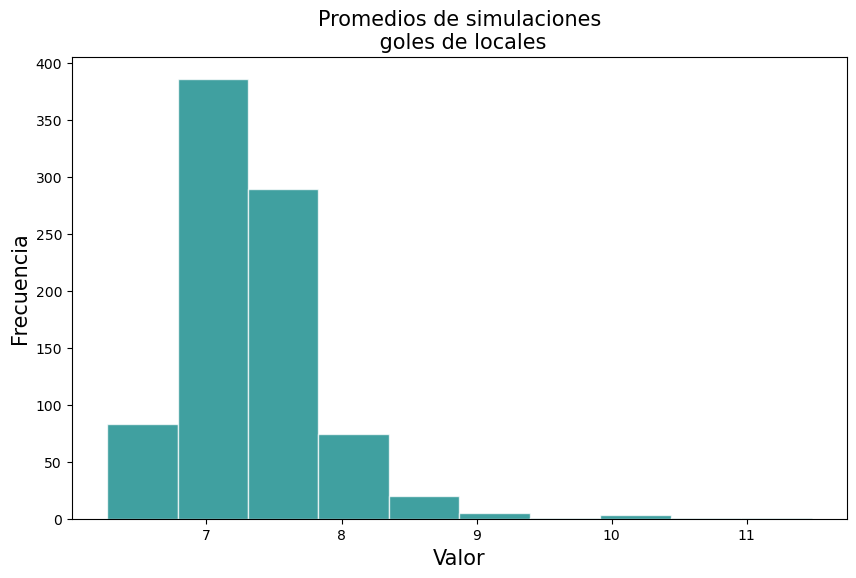

In [53]:
plot_histogram(column_means_y1, "Promedios de simulaciones\n goles de locales")

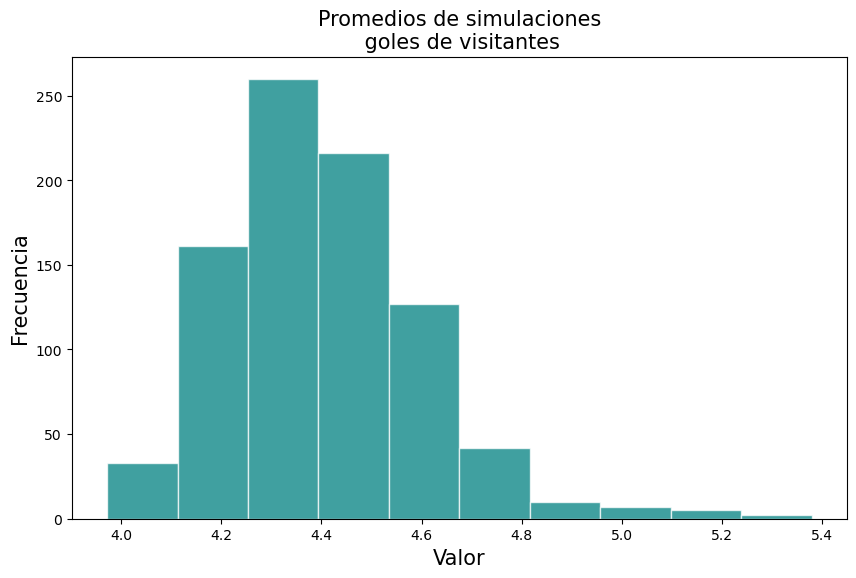

In [54]:
plot_histogram(column_means_y2, "Promedios de simulaciones\n goles de visitantes")